In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [2]:
# LR + Linear SVM + DT + RF
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
trainingData = pd.read_csv('Data/TRAIN_ExtractedFeatures&LABEL.csv')
X = trainingData.loc[:, trainingData.columns != 'LABEL']
y = trainingData['LABEL']

In [53]:
model = make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=250,C=4)) 
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
clf1 = Pipeline(steps=steps)

clf2 = make_pipeline(StandardScaler(), SVC(C=0.2, kernel='linear',probability=True))
clf3 = tree.DecisionTreeClassifier(random_state=10,criterion='entropy',max_features=25)
clf4 = RandomForestClassifier(random_state=10,max_features=25) 

In [71]:
#HARD VOTING
eclf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2), ('dt', clf3), ('rf', clf4)], voting='hard')

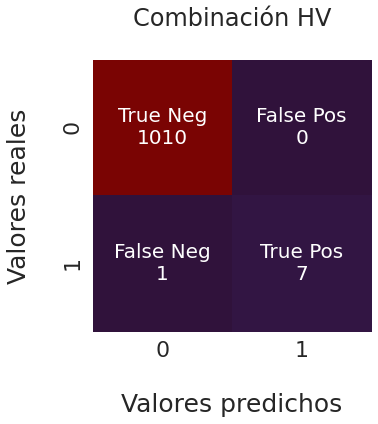

In [72]:
#CONFUSION MATRIX IN TRAINING (en una iteración de la validacion cruzada)

clf = eclf
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)

for train_index, test_index in cv.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    clf.fit(X_train,y_train)
    y_test = y.iloc[test_index].array
    y_pred = clf.predict(X.iloc[test_index])
    break
    

matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('Combinación HV\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Training/CM_Ensemble_HV.png', dpi=1000, bbox_inches="tight")

In [39]:
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}
scores = cross_validate(eclf, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.8392857142857142 +- 0.10101525445522107
Precision:
Test: 1.0 +- 0.0
Puntuación f4:
 Test: 0.8467156034977942 +- 0.09673107937216456


In [64]:
testData = pd.read_csv('Data/TEST_ExtractedFeatures&LABEL.csv')
X_test = testData.loc[:, testData.columns != 'LABEL']
y_test = testData['LABEL']
from sklearn.metrics import precision_recall_curve, auc

clf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2), ('dt', clf3), ('rf', clf4)], voting='soft')
#SOFT sin pesos es equivalente a HARD, para poder hacer predict_proba y calcular PR AUC
clf.fit(X,y)
y_pred = clf.predict(X_test)
print('precision:',precision_score(y_test, y_pred, average='binary')) # TP / (TP + FP)
print('recall:',recall_score(y_test, y_pred, average='binary')) # TP / (TP + FN)
print('f4:',fbeta_score(y_test, y_pred, beta=4, average="binary"))
precision, recall, _  = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
print('PR AUC:',auc(recall, precision))

precision: 1.0
recall: 0.6
f4: 0.6144578313253011
PR AUC: 0.818927304964539


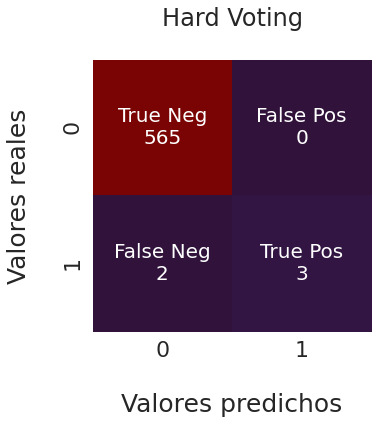

In [65]:
#CONFUSION MATRIX
matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('Hard Voting\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Test/CM_Ensemble_HV.png', dpi=1000, bbox_inches="tight")

In [73]:
#SOFT VOTING
eclf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2), ('dt', clf3), ('rf', clf4)], voting='soft',weights=[1,8,5,5])

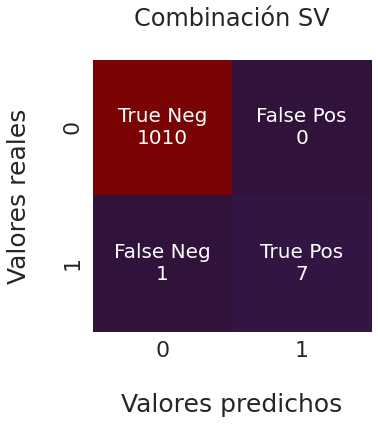

In [74]:
#CONFUSION MATRIX IN TRAINING (en una iteración de la validacion cruzada)

clf = eclf
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)

for train_index, test_index in cv.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    clf.fit(X_train,y_train)
    y_test = y.iloc[test_index].array
    y_pred = clf.predict(X.iloc[test_index])
    break
    

matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('Combinación SV\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Training/CM_Ensemble_SV.png', dpi=1000, bbox_inches="tight")

In [52]:
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}
scores = cross_validate(eclf, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.8392857142857142 +- 0.10101525445522107
Precision:
Test: 1.0 +- 0.0
Puntuación f4:
 Test: 0.8467156034977942 +- 0.09673107937216456


In [67]:
testData = pd.read_csv('Data/TEST_ExtractedFeatures&LABEL.csv')
X_test = testData.loc[:, testData.columns != 'LABEL']
y_test = testData['LABEL']
from sklearn.metrics import precision_recall_curve, auc

clf = VotingClassifier(estimators=[('lr', clf1), ('svm', clf2), ('dt', clf3), ('rf', clf4)], voting='soft',weights=[1,8,5,5])
clf.fit(X,y)
y_pred = clf.predict(X_test)
print('precision:',precision_score(y_test, y_pred, average='binary')) # TP / (TP + FP)
print('recall:',recall_score(y_test, y_pred, average='binary')) # TP / (TP + FN)
print('f4:',fbeta_score(y_test, y_pred, beta=4, average="binary"))
precision, recall, _  = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
print('PR AUC:',auc(recall, precision))

precision: 1.0
recall: 0.6
f4: 0.6144578313253011
PR AUC: 0.8366666666666667


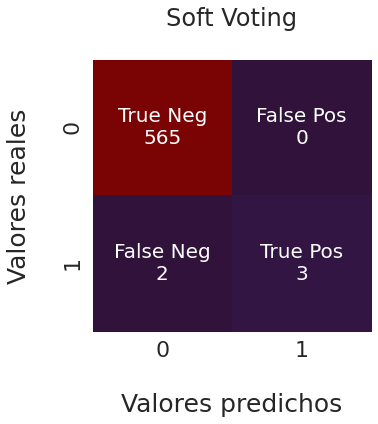

In [68]:
#CONFUSION MATRIX
matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('Soft Voting\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Test/CM_Ensemble_SV.png', dpi=1000, bbox_inches="tight")